In [1]:
import dotenv
import os

dotenv.load_dotenv("../.env")

True

# Fake example

## Create langchain model

In [2]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

E0000 00:00:1759218759.978651   15001 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


## Create fake data to test with

In [3]:
import polars as pl

# 1. Create a sample Polars DataFrame
data = {
    "trip_id": [1, 2, 3, 4, 5],
    "driver_id": [101, 102, 101, 103, 102],
    "pickup_location": ["Downtown", "Uptown", "Midtown", "Downtown", "Airport"],
    "dropoff_location": ["Airport", "Downtown", "Uptown", "Midtown", "Downtown"],
    "fare": [25.50, 15.75, 12.00, 8.50, 45.00],
    "rating": [5, 4, 5, 4, 5],
}

df = pl.DataFrame(data)

## Define agent state and graph nodes

In [4]:
import polars as pl
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate

import operator


# 2. Define the Agent State
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    result: str

In [ ]:
def generate_sql(state):
    """
    Generates SQL code for Polars from a user's question.
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                f"""
                    You are an expert in Polars and SQL. Generate a SQL query for the user's question, using the table 'df'.
                    Only output the SQL code, no explanations. Make sure you wrap the actual sql code in markdown triple backticks with 'sql' after the first three backticks.
                    Schema: {df.head()}
                """,
            ),
            ("user", "{question}"),
        ]
    )
    question = state["messages"][-1].content
    sql_code = model.invoke(prompt.format(question=question)).content
    return {"messages": [SystemMessage(content=f"Generated SQL:\n{sql_code}")]}


def execute_sql(state):
    """
    Executes the generated SQL code using Polars' SQL interface.
    """
    # Extract SQL code, removing possible markdown/code block wrappers
    sql_code = state["messages"][-1].content
    sql_code = sql_code.split("```")[1].replace("sql", "").strip()
    print(sql_code)
    try:
        result = pl.sql(sql_code).collect()
        result_str = result.to_pandas().to_markdown()
    except Exception as e:
        result_str = f"Error executing SQL: {e}"

    return {"messages": [SystemMessage(content=result_str)]}


def format_answer(state):
    """
    Formats the final answer to the user.
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
                    You are a helpful assistant. Provide a concise answer based on the SQL query result.
                    If the result is empty, say "No data found".
                """,
            ),
            ("user", "Based on the following SQL result, provide a concise answer:\n{result}"),
        ]
    )

    sql_result = state["messages"][-1].content
    if "Error executing SQL" in sql_result:
        answer = sql_result
    else:
        answer = model.invoke(prompt.format(result=sql_result)).content

    return {"result": answer}

In [23]:
from langgraph.graph import StateGraph, END

# 4. Build the Graph
graph_builder = StateGraph(AgentState)

graph_builder.add_node("generate_sql", generate_sql)
graph_builder.add_node("execute_sql", execute_sql)
graph_builder.add_node("format_answer", format_answer)

graph_builder.set_entry_point("generate_sql")
graph_builder.add_edge("generate_sql", "execute_sql")
graph_builder.add_edge("execute_sql", "format_answer")
graph_builder.add_edge("format_answer", END)

graph = graph_builder.compile()

In [24]:
result = graph.invoke(
    {
        "messages": [HumanMessage(content="What is the average fare for trips starting from Downtown?")],
    }
)

SELECT AVG(fare)
FROM df
WHERE pickup_location = 'Downtown';


In [25]:
print(result)
print(result["result"])

{'messages': [HumanMessage(content='What is the average fare for trips starting from Downtown?', additional_kwargs={}, response_metadata={}), SystemMessage(content="Generated SQL:\n```sql\nSELECT AVG(fare)\nFROM df\nWHERE pickup_location = 'Downtown';\n```", additional_kwargs={}, response_metadata={}), SystemMessage(content='|    |   fare |\n|---:|-------:|\n|  0 |     17 |', additional_kwargs={}, response_metadata={})], 'result': 'The fare is 17.'}
The fare is 17.


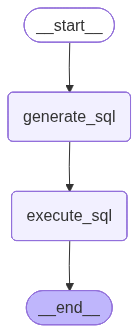

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))